# Stock Combination Testing and Weight Discovery

In [1]:
%matplotlib inline

import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import calculations 

In [2]:
data = pd.read_csv('Data_adjprice.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')
data.head()

,Date,0111145D US Equity,0202445Q US Equity,0203524D US Equity,0226226D US Equity,0376152D US Equity,0440296D US Equity,0544749D US Equity,0574018D US Equity,0598884D US Equity,...,YNR US Equity,YRCW US Equity,YUM US Equity,YUMC US Equity,ZBH US Equity,ZETHQ US Equity,ZION US Equity,ZRN US Equity,ZTS US Equity,ZTS-W US Equity
0,1993-09-07,13.2719,13.6829,8.4429,8.1042,11.000,57.3245,17.8887,6.8315,28.1246,...,NaN,144439.5121,NaN,NaN,NaN,6.875,7.1675,30.7970,NaN,NaN
1,1993-09-08,13.3263,13.5315,8.2147,7.9590,11.000,57.2096,17.8064,6.8315,27.5051,...,NaN,143691.1208,NaN,NaN,NaN,6.750,6.9766,30.0188,NaN,NaN
2,1993-09-09,13.7070,13.3800,8.7852,8.0627,11.125,59.1625,17.6831,6.8315,27.7529,...,NaN,143691.1208,NaN,NaN,NaN,6.625,6.9554,30.0188,NaN,NaN
3,1993-09-10,13.3807,13.4810,9.4127,8.0368,11.125,59.6220,17.6420,6.8773,27.5051,...,NaN,145187.9033,NaN,NaN,NaN,6.750,7.2099,29.6852,NaN,NaN
4,1993-09-11,13.3807,13.4810,9.4127,8.0368,11.125,59.6220,17.6420,6.8773,27.5051,...,NaN,145187.9033,NaN,NaN,NaN,6.750,7.2099,29.6852,NaN,NaN


First we create a basic function that can generate a large number of portfolios, measures their performance and returns the most profitable and lowest risk portfolios

In [3]:
#Function that generates the random weighting graph and finds the portfolio's with the best sharpe ratio and lowest risks
def random_portfolio_weighting_generator(stocks, portfolio_amount):
    number_of_portfolios = portfolio_amount
    RF = 0


    portfolio_returns = []
    portfolio_risk = []
    sharpe_ratio_port = []
    portfolio_weights = []

    for portfolio in range (number_of_portfolios):
    #generates a random weight of the length of our total stock in the portfolio (3 in our case)
        weights = np.random.random_sample(3)

        weights = weights / np.sum(weights)
        annualize_return = np.sum((stocks.mean() * weights) * 250)
        portfolio_returns.append(annualize_return)
      
    #variance
        matrix_covariance_portfolio = (stocks.cov())*250
        portfolio_variance = np.dot(weights.T,np.dot(matrix_covariance_portfolio, weights))
        portfolio_standard_deviation= np.sqrt(portfolio_variance) 
        portfolio_risk.append(portfolio_standard_deviation)
      
    #sharpe_ratio
        sharpe_ratio = ((annualize_return- RF)/portfolio_standard_deviation)
        sharpe_ratio_port.append(sharpe_ratio)

        portfolio_weights.append(weights)

    portfolio_risk = np.array(portfolio_risk)
    portfolio_returns = np.array(portfolio_returns)
    sharpe_ratio_port = np.array(sharpe_ratio_port)

    plt.figure(figsize=(10, 5))
    plt.scatter(portfolio_risk, portfolio_returns, c=portfolio_returns / portfolio_risk) 
    plt.xlabel('volatility')
    plt.ylabel('returns')
    plt.colorbar(label='Sharpe ratio')
    
    porfolio_metrics = [portfolio_returns,portfolio_risk,sharpe_ratio_port, portfolio_weights] 
    
    #from Python list we create a Pandas DataFrame
    portfolio_dfs = pd.DataFrame(porfolio_metrics)
    portfolio_dfs = portfolio_dfs.T
    
    #Rename the columns:
    portfolio_dfs.columns = ['Port Returns','Port Risk','Sharpe Ratio','Portfolio Weights']

    #convert from object to float the first three columns.
    for col in ['Port Returns', 'Port Risk', 'Sharpe Ratio']:
        portfolio_dfs[col] = portfolio_dfs[col].astype(float)
    portfolio_dfs

    #portfolio with the highest Sharpe Ratio
    Highest_sharpe_port = portfolio_dfs.iloc[portfolio_dfs['Sharpe Ratio'].idxmax()]
    
    #portfolio with the minimum risk 
    min_risk = portfolio_dfs.iloc[portfolio_dfs['Port Risk'].idxmin()]

    
    print("Highest Sharpe Ratio Portfolio")
    print(Highest_sharpe_port)
    print("Portfolio Weights", Highest_sharpe_port['Portfolio Weights'])
    print('\n')
    print("Lowest Risk Portfolio")
    print(min_risk)
    print("Portfolio Weights", Highest_sharpe_port['Portfolio Weights'])

## Basic Random Portfolio Generation
### Portfolio Containing Stocks with highest sharpe ratios
To be able to utilize the function. We have to reformat our dataframes to contain only the stocks that we want to investigate. Here sharpe1 is a dataframe that contains the stocks with the highest sharpe ratio, sharpe2 is the same as sharpe1 but has the date as its index, whilst sharpe3 is a dataframe showing the change in returns of sharpe2. 

We apply this 4 times to create our 4 portfolios of interest.

In [4]:
sharpestocks = ['Date','1530Q US Equity', 'PCP US Equity','2987536Q US Equity']
sharpe1 =  data.loc[ :, sharpestocks]
sharpe2 = sharpe1.set_index('Date')
sharpe2.pct_change()
sharpe3 = sharpe2.pct_change()

#Dataframe of 3 stocks with highest returns
ReturnStocks = ['Date', 'COO US Equity', 'HOLX US Equity','WDC US Equity']
Returns =  data.loc[:, ReturnStocks]
Returns2 = Returns.set_index('Date')
Returns3 = Returns2.pct_change()

#Dataframe of 3 stocks with lowest expected shortfall
ESstocks = ['Date','MNST US Equity','1288453D US Equity','GMCR US Equity']
shortfall =  data.loc[:, ESstocks]
shortfall2 = shortfall.set_index('Date')
shortfall3 = shortfall2.pct_change()

#Dataframe of 3 stocks, each with a highest returns, sharpe ratio or lowest expected shortfall
MixedComboStocks = ['Date', 'MNST US Equity', 'COO US Equity','1530Q US Equity']
Mixed =  data.loc[:, MixedComboStocks]
Mixed2 = Mixed.set_index('Date')
Mixed3 = Mixed2.pct_change()

sharpe3.head()

,1530Q US Equity,PCP US Equity,2987536Q US Equity
Date,,,
1993-09-07,NaN,NaN,NaN
1993-09-08,-0.014649,-0.005157,-0.010894
1993-09-09,-0.007433,-0.010641,0.011014
1993-09-10,0.007489,0.000000,0.043440
1993-09-11,0.000000,0.000000,0.000000


Highest Sharpe Ratio Portfolio
Port Returns                                                 0.0590851
Port Risk                                                      0.06979
Sharpe Ratio                                                  0.846612
Portfolio Weights    [0.7647882835797802, 0.1636036653648595, 0.071...
Name: 777, dtype: object
Portfolio Weights [0.76478828 0.16360367 0.07160805]


Lowest Risk Portfolio
Port Returns                                                 0.0419117
Port Risk                                                    0.0595798
Sharpe Ratio                                                  0.703454
Portfolio Weights    [0.9352971352524421, 0.023824092283234573, 0.0...
Name: 585, dtype: object
Portfolio Weights [0.76478828 0.16360367 0.07160805]


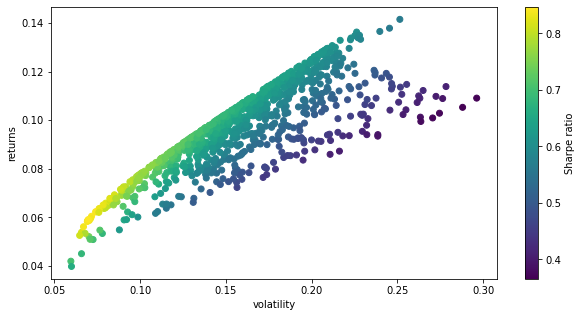

In [5]:
random_portfolio_weighting_generator(sharpe3, 1000)

In the graph, each point represents a portfolio. We see that portfolios with the higher Sharpe Ratio are shown as yellow. Yellow coloured portfolios are preferable since they offer better risk adjusted returns.
### Portfolio Containing Stocks with lowest Expected Shortfall

Highest Sharpe Ratio Portfolio
Port Returns                                                  0.301435
Port Risk                                                      0.38243
Sharpe Ratio                                                  0.788209
Portfolio Weights    [0.5427825536101102, 0.0007555925785321284, 0....
Name: 646, dtype: object
Portfolio Weights [0.54278255 0.00075559 0.45646185]


Lowest Risk Portfolio
Port Returns                                                  0.290232
Port Risk                                                       0.3758
Sharpe Ratio                                                  0.772303
Portfolio Weights    [0.020886261412320483, 0.4685453464473232, 0.5...
Name: 847, dtype: object
Portfolio Weights [0.54278255 0.00075559 0.45646185]


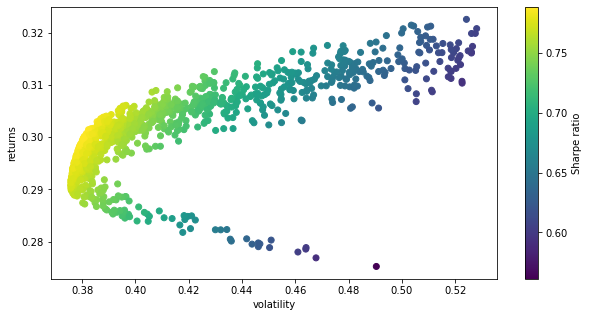

In [6]:
random_portfolio_weighting_generator(shortfall3, 1000)

### Portfolio Containing Stocks with Highest Returns

Highest Sharpe Ratio Portfolio
Port Returns                                                  0.230652
Port Risk                                                     0.289826
Sharpe Ratio                                                  0.795829
Portfolio Weights    [0.45774202282670245, 0.32063198224181677, 0.2...
Name: 674, dtype: object
Portfolio Weights [0.45774202 0.32063198 0.22162599]


Lowest Risk Portfolio
Port Returns                                                  0.226878
Port Risk                                                     0.287116
Sharpe Ratio                                                  0.790199
Portfolio Weights    [0.37467540630243346, 0.38145321599010634, 0.2...
Name: 315, dtype: object
Portfolio Weights [0.45774202 0.32063198 0.22162599]


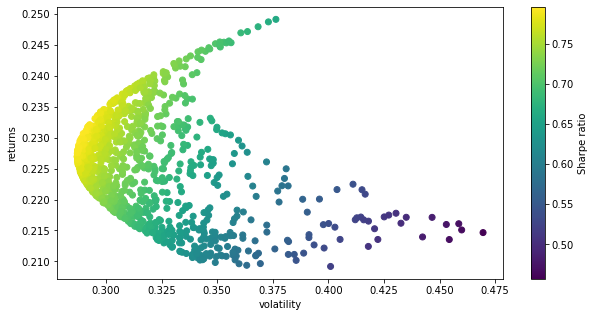

In [7]:
random_portfolio_weighting_generator(Returns3, 1000)

### Portfolio Containing Stocks with Highest Returns, Highest Sharpe Ratio and lowest Expected Shortfall

Highest Sharpe Ratio Portfolio
Port Returns                                                 0.0947195
Port Risk                                                    0.0931866
Sharpe Ratio                                                   1.01645
Portfolio Weights    [0.10422077988395426, 0.1290474503215934, 0.76...
Name: 640, dtype: object
Portfolio Weights [0.10422078 0.12904745 0.76673177]


Lowest Risk Portfolio
Port Returns                                                 0.0419216
Port Risk                                                     0.060809
Sharpe Ratio                                                  0.689398
Portfolio Weights    [0.0051348345769972915, 0.018605668743212473, ...
Name: 165, dtype: object
Portfolio Weights [0.10422078 0.12904745 0.76673177]


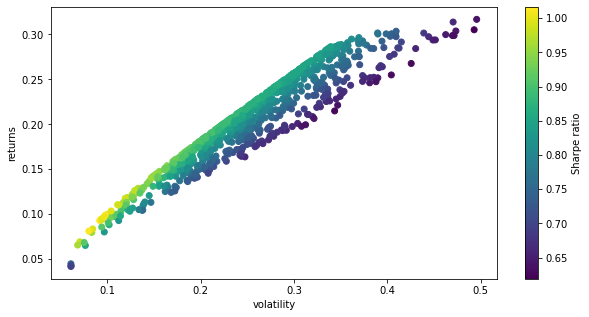

In [8]:
random_portfolio_weighting_generator(Mixed3, 1000)

## Markowitz Model Application

Having accomplished some simple random portfolio generation, we realise that we had bascially performed an rough application of the Markowitz Model. The Markowitz Model is a special method for computing a set profitable portfolio weights. It involves generating an extremely large number of portfolio's, each with different stock weightings/investments, then selecting the most efficient portfolio out of the large sample size based on specific metrics.

#### Efficient Frontier

The efficient frontier represents a number of stocks that offer the highest risk adjusted returns, basically offering the most profit while maintaining as low risk as possible

![image](https://www.guidedchoice.com/wp-content/uploads/2017/07/mpt-image-2.jpg)

In [9]:
returns = Mixed3
mean_returns = returns.mean()
cov_matrix = returns.cov() #covariance
num_portfolios = 10000
risk_free_rate = 0.0081

From our data visualisation and analysis earlier, we saw that the mixed portfolio contained stocks that could obtain the highest sharpe ratio (of approximately above 1 in most cases) out of all four different portfolios. So we will apply our markowitz model analysis to the mixed stock portfolio.

#### Risk Free Rate

Represents the interest rate that investors can expect over a specific time period. Using websites such as https://ycharts.com/indicators/10_year_treasury_rate, we can search up the present risk free rate and safely accept that it is 0.81% as of the 26th of October 2020.

In [10]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(3)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
        
    return results, weights_record

In [11]:

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, portfolio):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=portfolio.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=portfolio.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*60)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,4))
    print("Annualised Volatility:", round(sdp,4))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*60)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,4))
    print("Annualised Volatility:", round(sdp_min,4))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='Purples', marker='o', s=10, alpha=0.8)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='X',color='y',s=180, label='Maximum Sharpe Ratio Portfolio')
    plt.scatter(sdp_min,rp_min,marker='X',color='r',s=180, label='Minimum Volatility Portfolio')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised volatility')
    plt.ylabel('Annualised returns')
    plt.legend(labelspacing=0.8)

------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.0974
Annualised Volatility: 0.0956


            MNST US Equity  COO US Equity  1530Q US Equity
allocation           10.65          13.47            75.88
------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.0432
Annualised Volatility: 0.061


            MNST US Equity  COO US Equity  1530Q US Equity
allocation            0.86           1.81            97.33


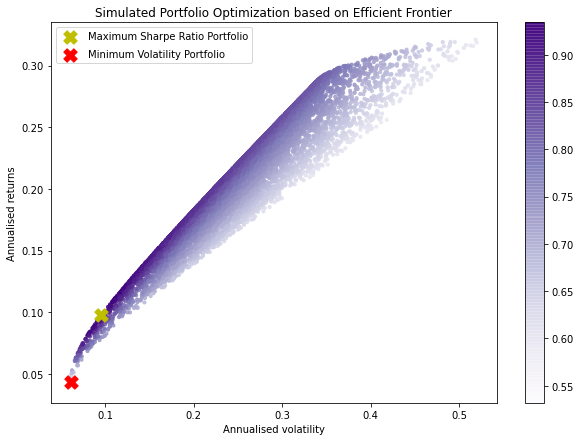

In [23]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, Mixed2)

#### Annualised Returns
The amount of profit you can expect from the portfolio over the course of a year. Eg, if you invested \\$1000 with an annualised return of 0.15, you can expect \\$150 in returns. Of course this is subject to annualised volatility.

#### Annualised Volatility
Represents the

## Efficient Frontier Focus
Now that we have employed the Markowitz Model to obtain a basic idea of the shape of our portfolio's we need to acquire the efficient frontier. 

In [13]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

Above is a function that captures our portfolio with the highest sharpe ratio. To do this we utilize Scipy, Scipy does not have have a maximise function but we can counter this by simply obtaining the negative sharpe ratio instead and using Scipy to minimise that.

The above constraint is also utilized, as it sets a contraint that the sum of all our portfolio weights is equal to one.

In [14]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [15]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
        
    return efficients

In [16]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, portfolio):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=portfolio.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=portfolio.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
     
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='Purples', marker='o', s=10, alpha=0.8)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='X',color='y',s=180, label='Maximum Sharpe Ratio Portfolio')
    plt.scatter(sdp_min,rp_min,marker='X',color='r',s=180, label='Minimum Volatility Portfolio')
    



    target = np.linspace(rp_min, 0.32, 50, endpoint = True) #0.32 = where the line stops in terms of annual returns
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised volatility')
    plt.ylabel('Annualised returns')
    plt.legend(labelspacing=0.8)
    
    print("-"*60)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,4))
    print("Annualised Volatility:", round(sdp,4))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*60)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,4))
    print("Annualised Volatility:", round(sdp_min,4))
    print("\n")
    print(min_vol_allocation)

------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.0996
Annualised Volatility: 0.0979


            MNST US Equity  COO US Equity  1530Q US Equity
allocation           11.22          13.72            75.06
------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.0435
Annualised Volatility: 0.0609


            MNST US Equity  COO US Equity  1530Q US Equity
allocation            1.26           1.45             97.3


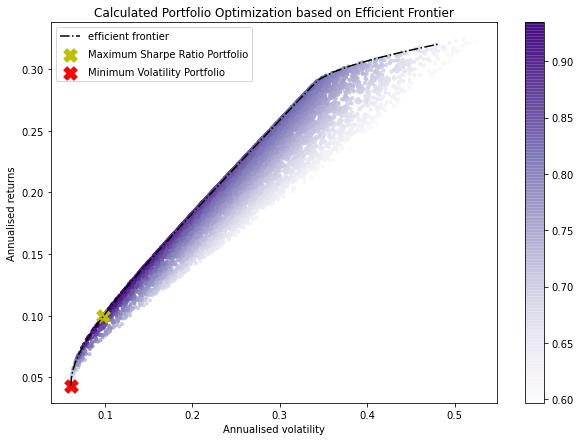

In [20]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, Mixed2)

## Finalizations

In [18]:

def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate, portfolio):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=portfolio.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=portfolio.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(portfolio.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='X',color='y',s=180, label='Maximum Sharpe Ratio Portfolio')
    ax.scatter(sdp_min,rp_min,marker='X',color='r',s=180, label='Minimum Volatility Portfolio')

    target = np.linspace(rp_min, 0.325, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('Annualised volatility')
    ax.set_ylabel('Annualised returns')
    ax.legend(labelspacing=0.8)
    
    print("-"*60)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,4))
    print("Annualised Volatility:", round(sdp,4))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*60)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,4))
    print("Annualised Volatility:", round(sdp_min,4))
    print("\n")
    print(min_vol_allocation)
    print("-"*60)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(portfolio.columns):
        print(txt,":","Annuaised return",round(an_rt[i],2),", Annualised volatility:",round(an_vol[i],2))
    print("-"*60)

------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.0996
Annualised Volatility: 0.0979


            MNST US Equity  COO US Equity  1530Q US Equity
allocation           11.22          13.72            75.06
------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.0435
Annualised Volatility: 0.0609


            MNST US Equity  COO US Equity  1530Q US Equity
allocation            1.26           1.45             97.3
------------------------------------------------------------
Individual Stock Returns and Volatility

MNST US Equity : Annuaised return 0.33 , Annualised volatility: 0.54
COO US Equity : Annuaised return 0.26 , Annualised volatility: 0.42
1530Q US Equity : Annuaised return 0.04 , Annualised volatility: 0.06
------------------------------------------------------------


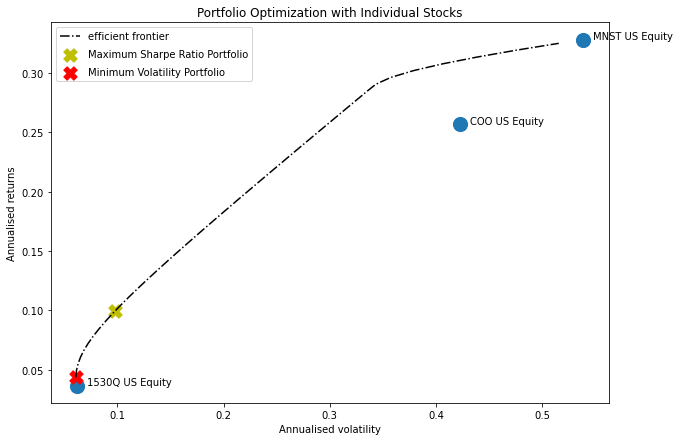

In [24]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate, Mixed2)

The blue dots represents the performance of the single stocks. Dots under the curve, even though they may have higher annualised returns, still offer a much more dangerous volatility risk. The MNST stock looks convicing to invest in, however note that only all funds into a single stock is significantly more risky than investing in an entire portfolio, as a simple change in price of a stock would ruin your single stock profits.